In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from einops import repeat
from pathlib import Path

import pytorch_lightning

from bliss.catalog import convert_flux_to_magnitude, TileCatalog

In [2]:
cmap = plt.get_cmap("Dark2")
def get_color(i):
    assert i < 8
    return cmap(i)

In [3]:
cached_data_path = Path("/data/scratch/pduan/posterior_cached_files")

In [4]:
seed = 7272
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [5]:
cached_file_name_dict = {
    "bliss": "m2_cond_true_bliss_posterior_exp_04-20-3_encoder_31.ckpt_b_800_iter_500_seed_7272.pt",
    "simple_net": "m2_simple_net_posterior_exp_04-20-1_encoder_32.ckpt_b_800_iter_500_seed_7272.pt",
    "mdt": "m2_mdt_posterior_exp_04-19-1_encoder_76.ckpt_b_400_iter_300_seed_7272.pt",
    "mdt_speed": "m2_mdt_speed_posterior_exp_04-21-2_encoder_97.ckpt_b_400_iter_500_seed_7272.pt",
}

In [6]:
cached_data_dict = {}
for k, v in cached_file_name_dict.items():
    with open(cached_data_path / v, "rb") as f:
        cached_data_dict[k] = torch.load(f, map_location="cpu")

### Fluxes CI

In [7]:
def plot_data_for_fluxes_ci(result_dict, ci_cover, flux_min, flux_max):
    target_tile_cat = TileCatalog(d={
        "n_sources": result_dict["target_n_sources"],
        "locs": result_dict["target_locs"],
        "fluxes": result_dict["target_fluxes"],
    })
    target_tile_cat1 = target_tile_cat.get_brightest_sources_per_tile(band=0, exclude_num=0)
    target_tile_cat2 = target_tile_cat.get_brightest_sources_per_tile(band=0, exclude_num=1)
    target_n_sources_mask = torch.cat([target_tile_cat1.is_on_mask,
                                       target_tile_cat2.is_on_mask],
                                       dim=-1)  # (b, h, w, 2)
    target_fluxes = torch.cat([target_tile_cat1["fluxes"],
                               target_tile_cat2["fluxes"]],
                               dim=-2)  # (b, h, w, 2, 1)
    on_mask_target_fluxes = target_fluxes[target_n_sources_mask].view(-1, 1)  # (matched_sources, 1)
    pred_fluxes = torch.stack(result_dict["fluxes_list"], dim=0)  # (iter, b, h, w, 2, 1)
    pred_n_sources_mask = repeat(target_n_sources_mask, "... -> iter ...", iter=pred_fluxes.shape[0])
    on_mask_pred_fluxes = pred_fluxes[pred_n_sources_mask].view(pred_fluxes.shape[0], -1, 1)  # (iter, matched_sources, 1)

    left_q_points = [(1.0 - c) / 2 for c in ci_cover]
    right_q_points = [1.0 - lq for lq in left_q_points]
    actual_ci_cover = {band: [] for band in "r"}
    for q in zip(left_q_points, right_q_points):
        q = torch.tensor(q)
        on_mask_est_flux_q = on_mask_pred_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (matched_sources, 1, 2)
        for i, band in zip(range(1), "r"):
            above_lower_bound = on_mask_target_fluxes[:, i] > on_mask_est_flux_q[:, i, 0]
            below_upper_bound = on_mask_target_fluxes[:, i] < on_mask_est_flux_q[:, i, 1]  # (matched_sources, )
            valid_flux_mask = (on_mask_target_fluxes[:, i] > flux_min) & (on_mask_target_fluxes[:, i] <= flux_max)  # (matched_sources, )
            actual_ci_cover[band].append(((above_lower_bound & below_upper_bound)[valid_flux_mask].sum() / valid_flux_mask.sum()).item())
    
    for k, v in actual_ci_cover.items():
        actual_ci_cover[k] = torch.tensor(v)

    return actual_ci_cover

In [8]:
def draw_fluxes_ci_plot(flux_min, flux_max):
    ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
    fluxes_ci_dict = {}
    for k, v in cached_data_dict.items():
        fluxes_ci_dict[k] = plot_data_for_fluxes_ci(v, 
                                                    ci_cover=ci_cover,
                                                    flux_min=flux_min, 
                                                    flux_max=flux_max)
    # fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    # axes = np.array(axes)
    # for i, (ax, band) in enumerate(zip(axes.flatten(), "r")):
    #     for ki, (k, v) in enumerate(fluxes_ci_dict.items()):
    #         ax.plot(ci_cover, v[band], label=k.upper(), color=get_color(ki))
    #     ax.plot(ci_cover, ci_cover, linestyle="dashed", label="Expected Coverage")
    #     ax.set_xlabel("Expected CI Coverage")
    #     ax.set_ylabel("Actual CI Coverage")
    #     if i == 0:
    #         ax.legend()
    #     ax.set_title(f"Band {band}")
    #     ax.set_xticks(ci_cover)
    #     ax.tick_params(axis="x", labelrotation=45)
    #     ax.set_yticks(ci_cover)
    #     ax.grid()
    # fig.suptitle(f"Flux [{flux_min:.1f}, {flux_max:.1f}]")
    # fig.tight_layout()
    # fig.show()

    fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    axes = np.array(axes)
    for i, (ax, band) in enumerate(zip(axes.flatten(), "r")):
        for ki, (k, v) in enumerate(fluxes_ci_dict.items()):
            ax.plot(ci_cover, v[band] - ci_cover, label=k.upper(), color=get_color(ki))
        ax.axhline(y=0, linestyle="dashed", label="Expected", color="green")
        ax.set_xlabel("Expected CI Coverage")
        ax.set_ylabel("Actual - Expected CI Coverage")
        if i == 0:
            ax.legend()
        ax.set_title(f"Band {band}")
        ax.set_xticks(ci_cover)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid()
    fig.suptitle(f"Flux [{flux_min:.1f}, {flux_max:.1f}]")
    fig.tight_layout()
    fig.show()

    # fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    # axes = np.array(axes)
    # for i, (ax, band) in enumerate(zip(axes.flatten(), "r")):
    #     for ki, (k, v) in enumerate(fluxes_ci_dict.items()):
    #         ax.plot(ci_cover, (v[band] - ci_cover).abs(), label=k.upper(), color=get_color(ki))
    #     ax.axhline(y=0, linestyle="dashed", label="Expected", color="green")
    #     ax.set_xlabel("Expected CI Coverage")
    #     ax.set_ylabel("|Actual - Expected| CI Coverage")
    #     if i == 0:
    #         ax.legend()
    #     ax.set_title(f"Band {band}")
    #     ax.set_xticks(ci_cover)
    #     ax.tick_params(axis="x", labelrotation=45)
    #     ax.grid()
    # fig.suptitle(f"Flux [{flux_min:.1f}, {flux_max:.1f}]")
    # fig.tight_layout()
    # fig.show()

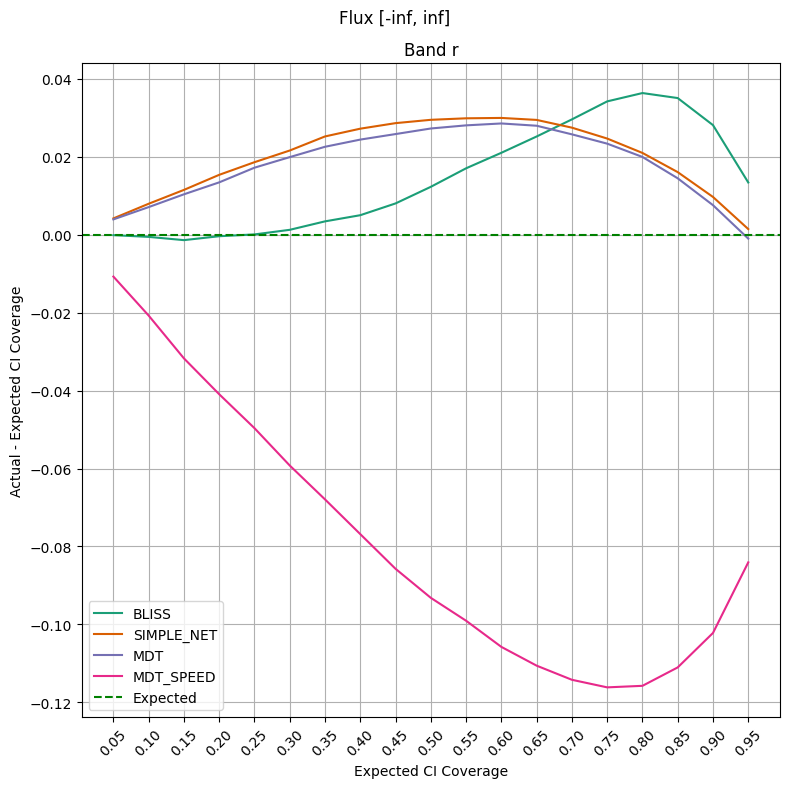

In [9]:
draw_fluxes_ci_plot(flux_min=-torch.inf, flux_max=torch.inf)

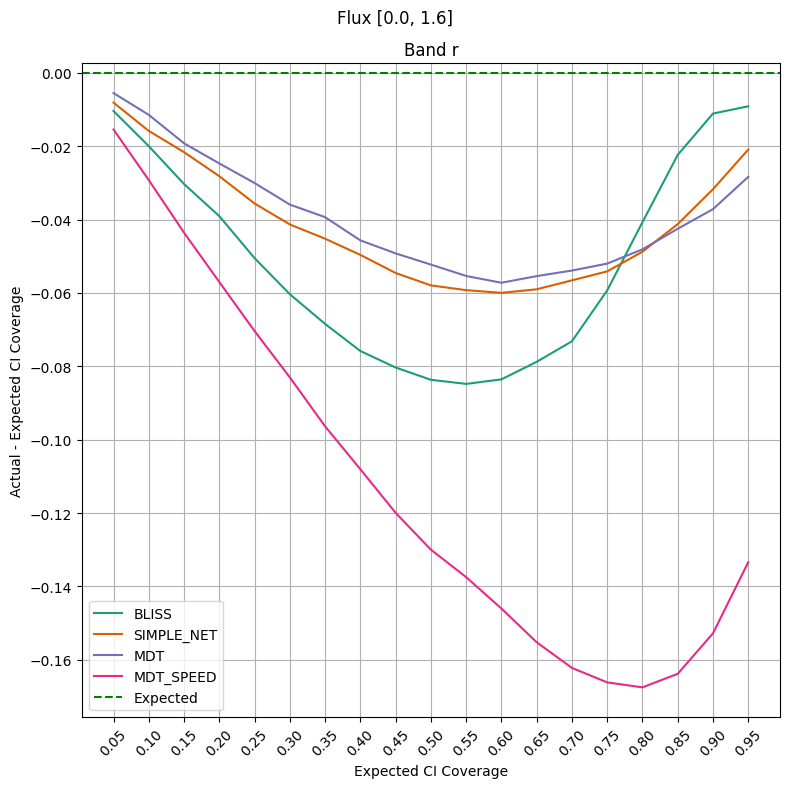

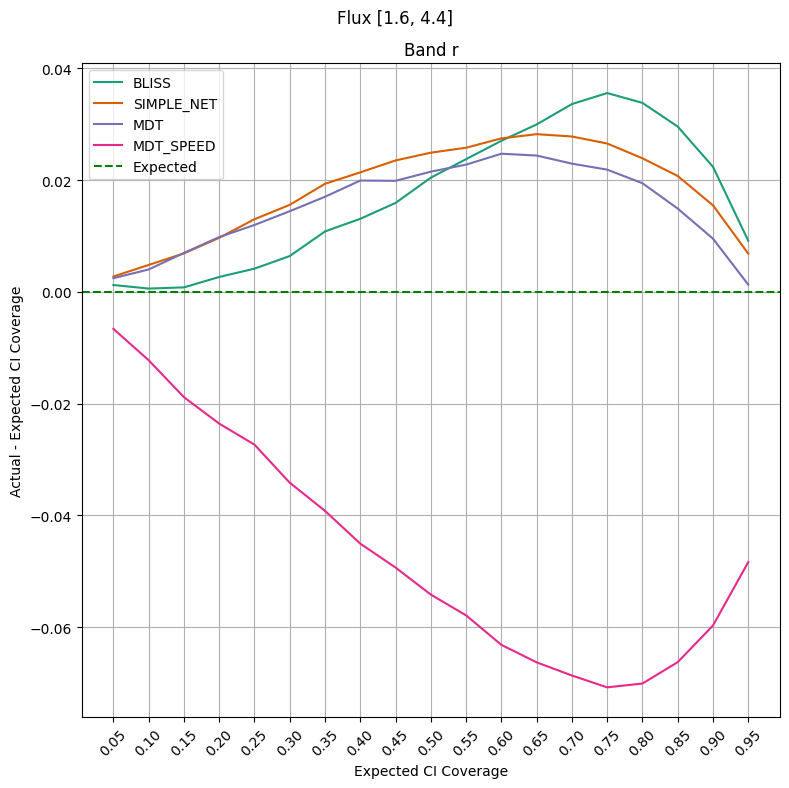

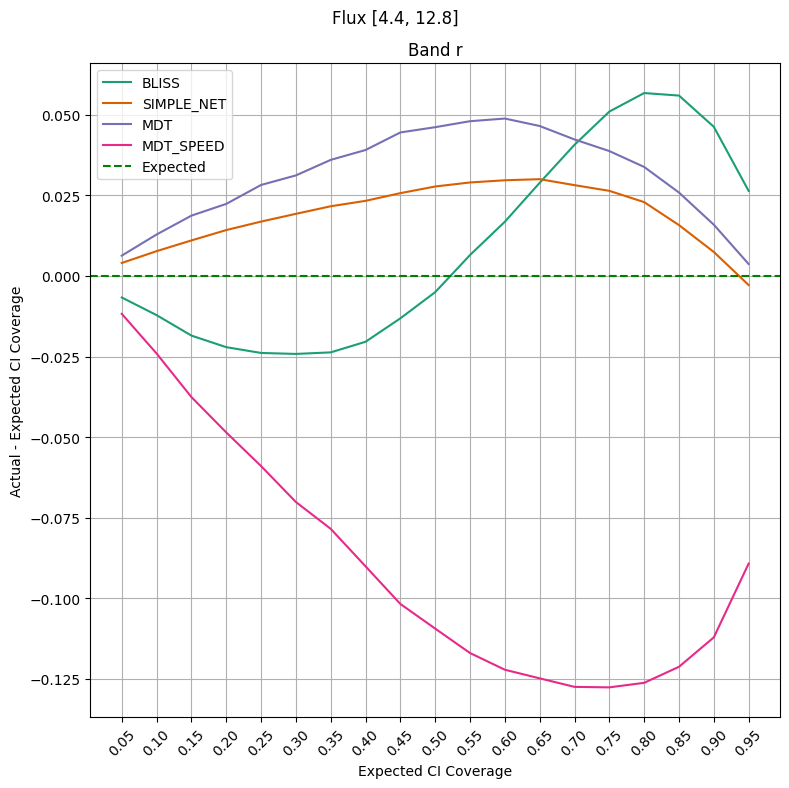

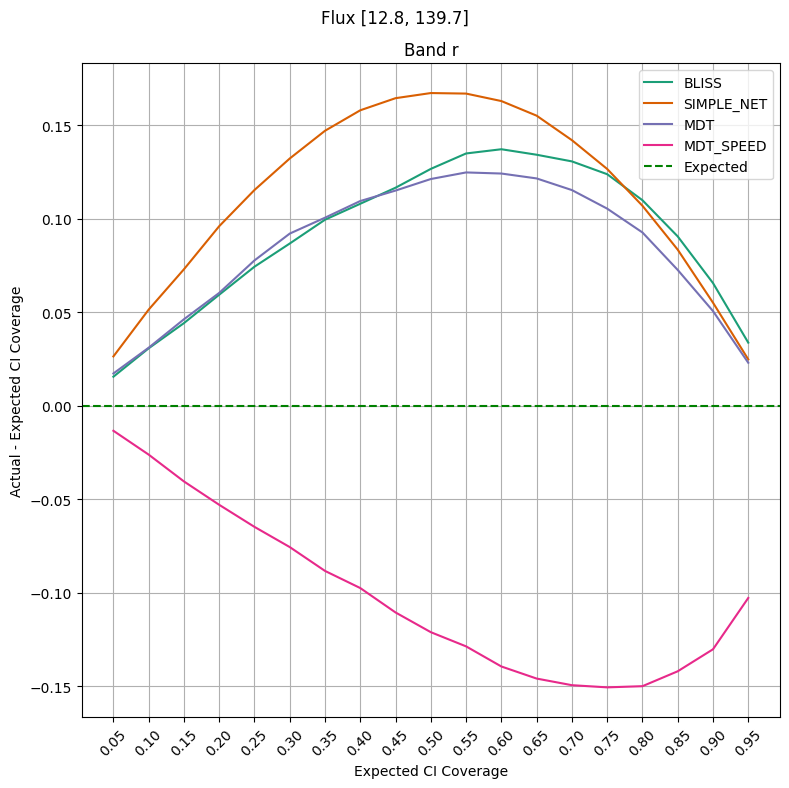

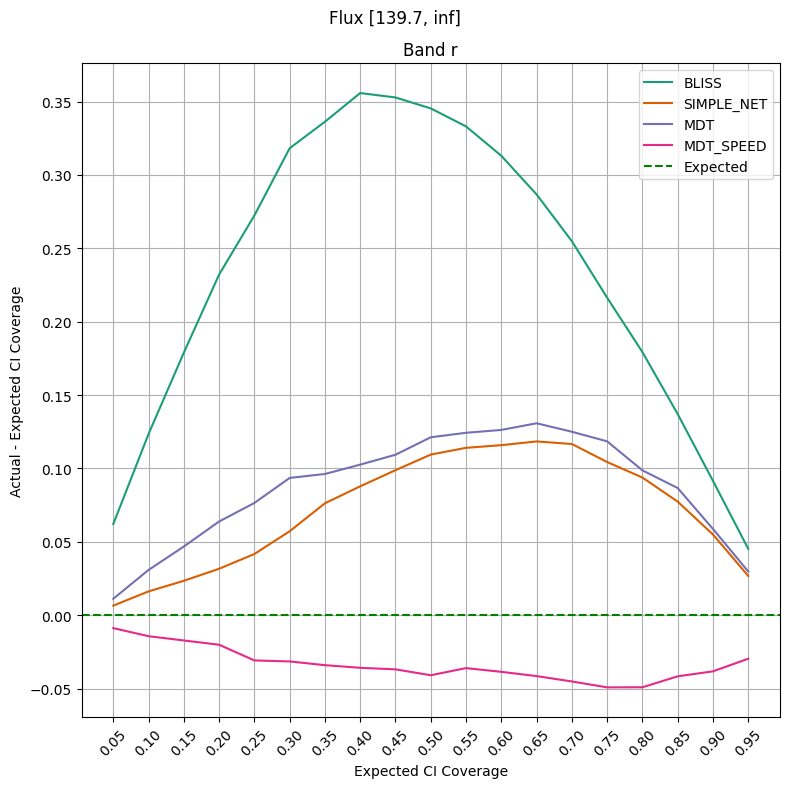

In [10]:
flux_boundaries = [0.0, 1.58, 4.37, 12.80, 139.70, torch.inf]
for flux_min, flux_max in zip(flux_boundaries[:-1], flux_boundaries[1:]):
    draw_fluxes_ci_plot(flux_min=flux_min, flux_max=flux_max)

### Fluxes CI Match

In [11]:
def plot_data_for_fluxes_ci_match(result_dict, ci_cover: float):
    target_tile_cat = TileCatalog(d={
        "n_sources": result_dict["target_n_sources"],
        "locs": result_dict["target_locs"],
        "fluxes": result_dict["target_fluxes"],
    })
    target_tile_cat1 = target_tile_cat.get_brightest_sources_per_tile(band=0, exclude_num=0)
    target_tile_cat2 = target_tile_cat.get_brightest_sources_per_tile(band=0, exclude_num=1)
    target_n_sources_mask = torch.cat([target_tile_cat1.is_on_mask,
                                       target_tile_cat2.is_on_mask],
                                       dim=-1)  # (b, h, w, 2)
    target_fluxes = torch.cat([target_tile_cat1["fluxes"],
                               target_tile_cat2["fluxes"]],
                               dim=-2)  # (b, h, w, 2, 1)
    on_mask_target_fluxes = target_fluxes[target_n_sources_mask].view(-1, 1)  # (matched_sources, 1)
    pred_fluxes = torch.stack(result_dict["fluxes_list"], dim=0)  # (iter, b, h, w, 2, 1)
    pred_n_sources_mask = repeat(target_n_sources_mask, "... -> iter ...", iter=pred_fluxes.shape[0])
    on_mask_pred_fluxes = pred_fluxes[pred_n_sources_mask].view(pred_fluxes.shape[0], -1, 1)  # (iter, matched_sources, 1)

    left_q_point = (1.0 - ci_cover) / 2
    right_q_point = 1.0 - left_q_point
    q = torch.tensor([left_q_point, right_q_point])
    on_mask_est_flux_q = on_mask_pred_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (matched_sources, 1, 2)
    on_mask_target_and_est_q = torch.cat([on_mask_target_fluxes.unsqueeze(-1), on_mask_est_flux_q], dim=-1)  # (matched_sources, 1, 3)
    return {
        band: convert_flux_to_magnitude(v.squeeze(1), zero_point=1e9) 
        for band, v in zip("r", on_mask_target_and_est_q.chunk(1, dim=1))
    }

In [12]:
def draw_fluxes_ci_match_plot(ci_cover):
    fluxes_ci_match_dict = {}
    for k, v in cached_data_dict.items():
        fluxes_ci_match_dict[k] = plot_data_for_fluxes_ci_match(v, ci_cover=ci_cover)
    for method_i, (method_name, t_flux_and_est_q) in enumerate(fluxes_ci_match_dict.items()):
        fig, axes = plt.subplots(1, 1, figsize=(8, 8))
        axes = np.array(axes)
        for i, (ax, band) in enumerate(zip(axes.flatten(), "r")):
            cur_band_data = t_flux_and_est_q[band]
            target_flux = cur_band_data[:, 0]
            est_lb_err = (cur_band_data[:, 1] - target_flux).abs()
            est_ub_err = (cur_band_data[:, 2] - target_flux).abs()
            est_err = torch.stack([est_lb_err, est_ub_err], dim=0)
            ax.errorbar(x=target_flux, 
                        y=cur_band_data[:, 1:].mean(dim=-1), 
                        yerr=est_err, 
                        fmt="none",
                        color=get_color(method_i))
            low_mag, high_mag = 12.0, 23.0
            ax.plot([low_mag, high_mag], [low_mag, high_mag], linestyle="dashed", label="Ref Line")
            ax.set_xlabel("True Magnitude")
            ax.set_ylabel(f"Est Magnitude {int(ci_cover * 100)}% CI")
            ax.set_title(f"Band {band}")
            ax.set_xlim(left=low_mag, right=high_mag)
            ax.set_ylim(bottom=low_mag, top=high_mag)
        fig.suptitle(f"Method: {method_name.upper()}")
        fig.tight_layout()
        fig.show()

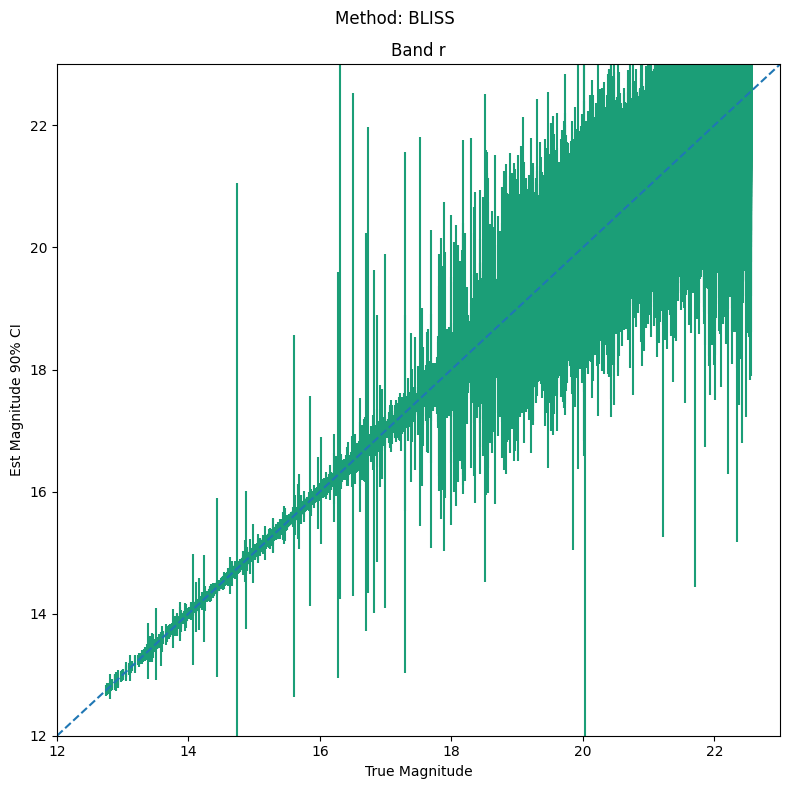

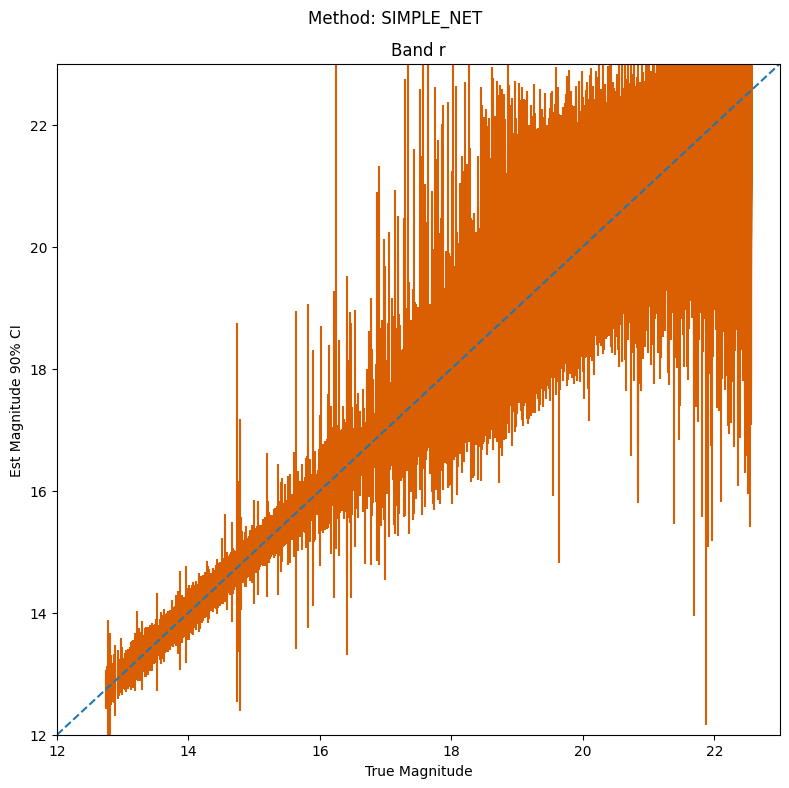

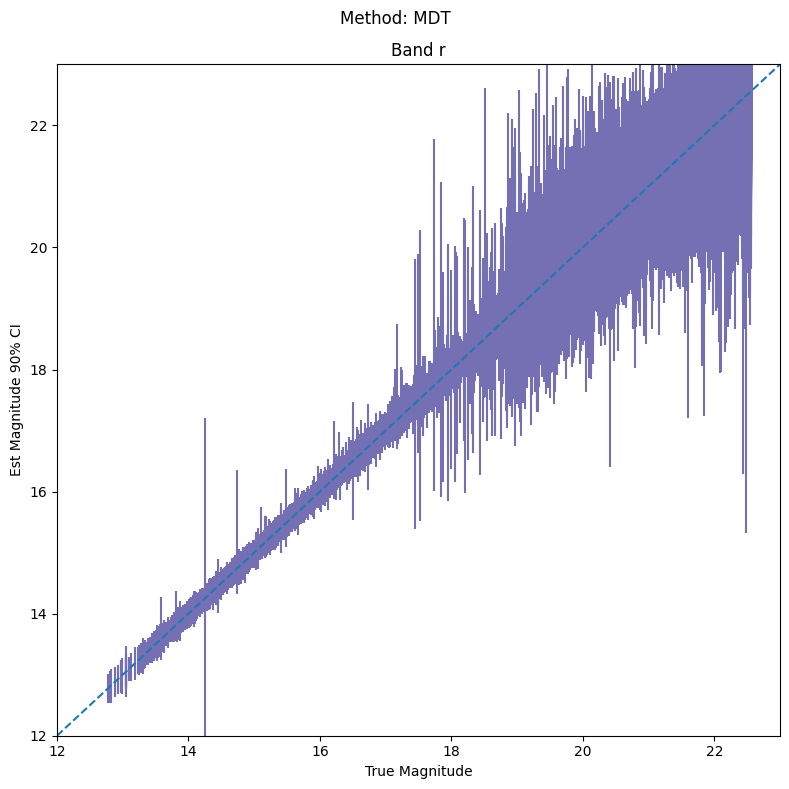

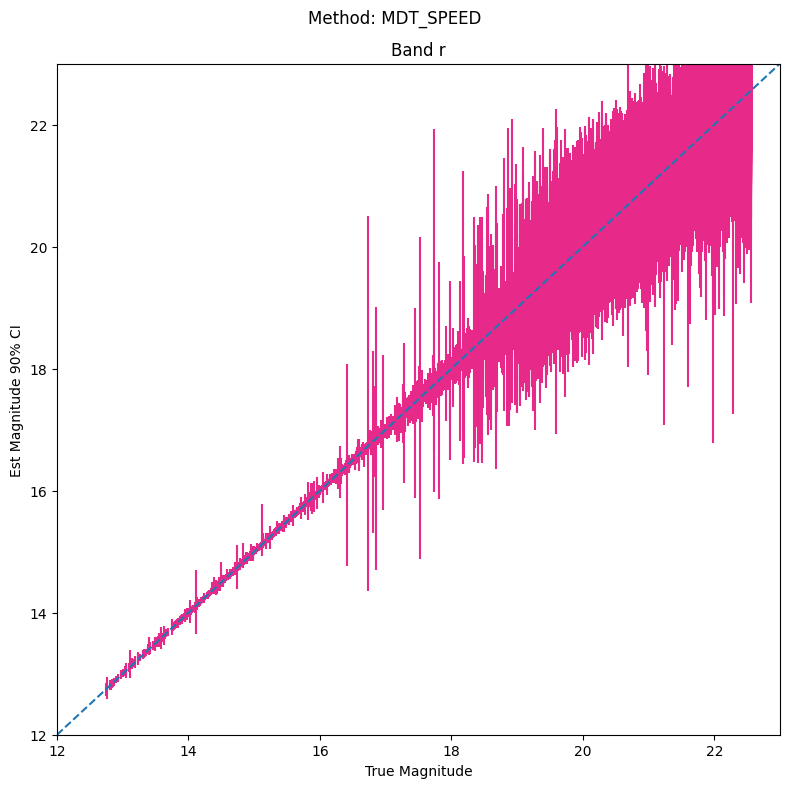

In [13]:
draw_fluxes_ci_match_plot(ci_cover=0.90)

### Flux Density

In [14]:
convert_flux_to_magnitude(torch.tensor(0.9419), zero_point=1e9)

tensor(22.5650)

In [15]:
convert_flux_to_magnitude(torch.tensor(50), zero_point=1e9)

tensor(18.2526)

In [16]:
convert_flux_to_magnitude(torch.tensor(1e2), zero_point=1e9)

tensor(17.5000)

In [17]:
convert_flux_to_magnitude(torch.tensor(1e3), zero_point=1e9)

tensor(15.)

In [18]:
convert_flux_to_magnitude(torch.tensor(1e4), zero_point=1e9)

tensor(12.5000)

In [19]:
def plot_data_for_flux_density(result_dict):
    target_tile_cat = TileCatalog(d={
        "n_sources": result_dict["target_n_sources"],
        "locs": result_dict["target_locs"],
        "fluxes": result_dict["target_fluxes"],
    })
    target_tile_cat1 = target_tile_cat.get_brightest_sources_per_tile(band=0, exclude_num=0)
    target_tile_cat2 = target_tile_cat.get_brightest_sources_per_tile(band=0, exclude_num=1)
    target_n_sources_mask = torch.cat([target_tile_cat1.is_on_mask,
                                       target_tile_cat2.is_on_mask],
                                       dim=-1)  # (b, h, w, 2)
    target_fluxes = torch.cat([target_tile_cat1["fluxes"],
                               target_tile_cat2["fluxes"]],
                               dim=-2)  # (b, h, w, 2, 1)
    on_mask_target_fluxes = target_fluxes[target_n_sources_mask].view(-1, 1)  # (matched_sources, 1)
    pred_fluxes = torch.stack(result_dict["fluxes_list"], dim=0)  # (iter, b, h, w, 2, 1)
    pred_n_sources_mask = repeat(target_n_sources_mask, "... -> iter ...", iter=pred_fluxes.shape[0])
    on_mask_pred_fluxes = pred_fluxes[pred_n_sources_mask].view(pred_fluxes.shape[0], -1, 1)  # (iter, matched_sources, 1)

    return on_mask_target_fluxes, on_mask_pred_fluxes

In [20]:
def draw_flux_density_plot(draw_kde):
    fluxes_density_match_dict = {}
    for k, v in cached_data_dict.items():
        fluxes_density_match_dict[k] = plot_data_for_flux_density(v)
    for method_i, (method_name, (t_fluxes, pred_fluxes)) in enumerate(fluxes_density_match_dict.items()):
        fig, axes = plt.subplots(1, 1, figsize=(8, 8))
        axes = np.array(axes)
        for i, (ax, band) in enumerate(zip(axes.flatten(), "r")):
            t_mag = convert_flux_to_magnitude(t_fluxes.flatten(), zero_point=1e9)
            est_mag = convert_flux_to_magnitude(pred_fluxes.flatten(), zero_point=1e9)
            t_mag = t_mag[torch.randperm(len(t_mag))[:10_000]]
            est_mag = est_mag[torch.randperm(len(est_mag))[:10_000]]
            if draw_kde:
                sns.kdeplot(t_mag, 
                            label="True", fill=True, alpha=0.4, ax=ax)
                sns.kdeplot(est_mag, 
                            label="Estimated", fill=True, alpha=0.4, ax=ax)
            else:
                ax.hist(t_mag, 
                        bins=100, label="True", alpha=0.4, density=True, log=True)
                ax.hist(est_mag, 
                        bins=100, label="Estimated", alpha=0.4, density=True, log=True)
            ax.set_xlabel("Magnitude")
            ax.set_ylabel("Density")
            ax.set_title(f"Band {band}")
            ax.legend()
        fig.suptitle(f"Method: {method_name.upper()}")
        fig.tight_layout()
        fig.show()

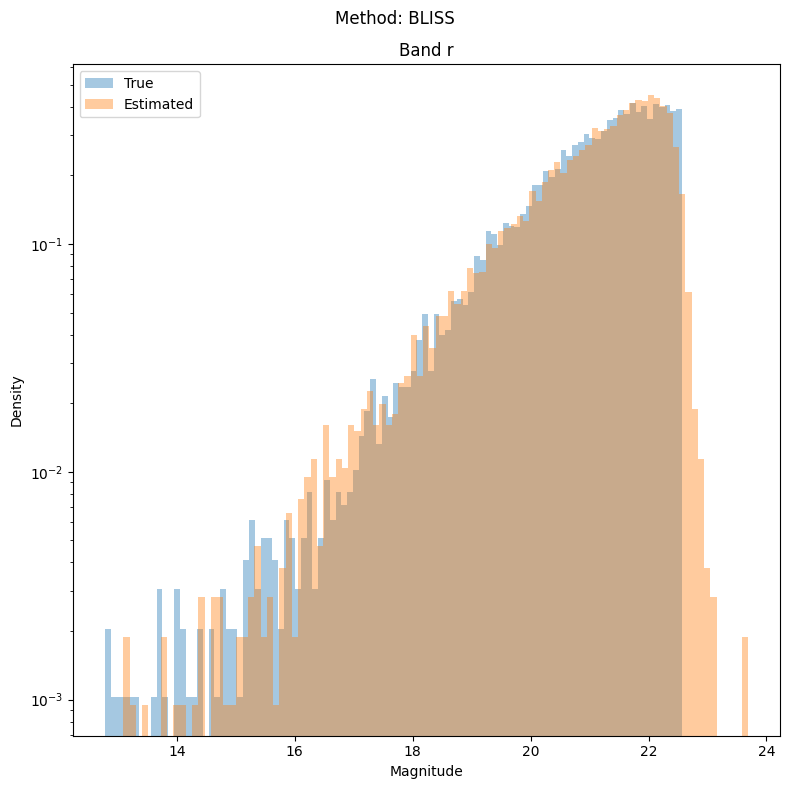

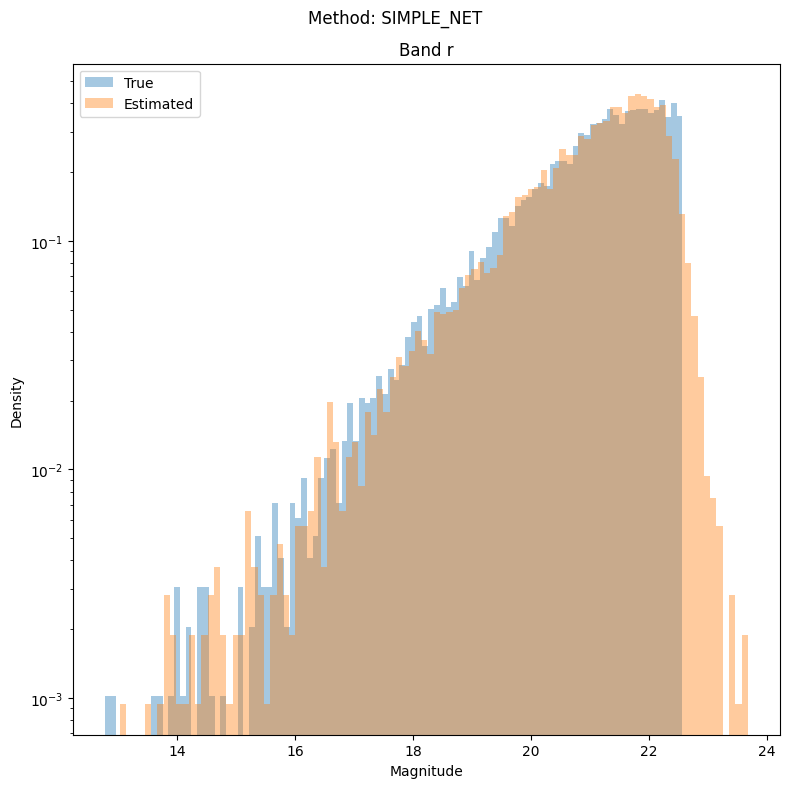

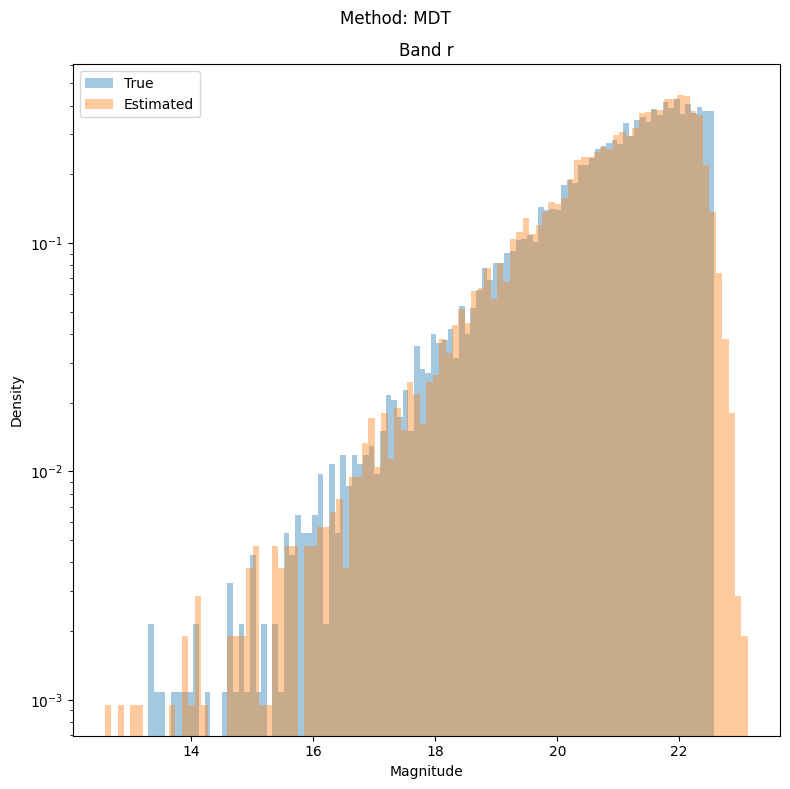

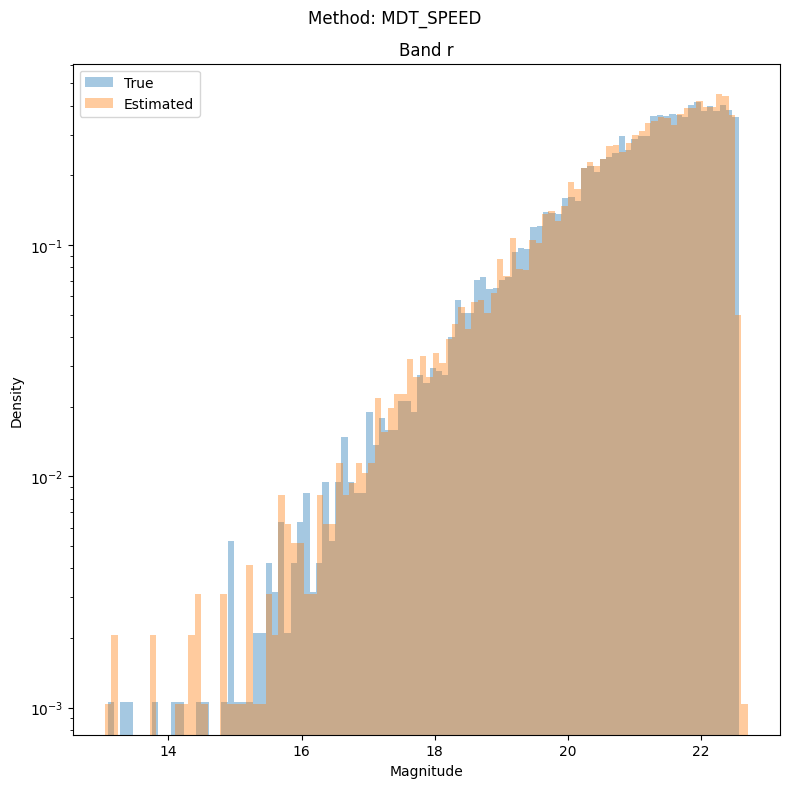

In [21]:
draw_flux_density_plot(draw_kde=False)

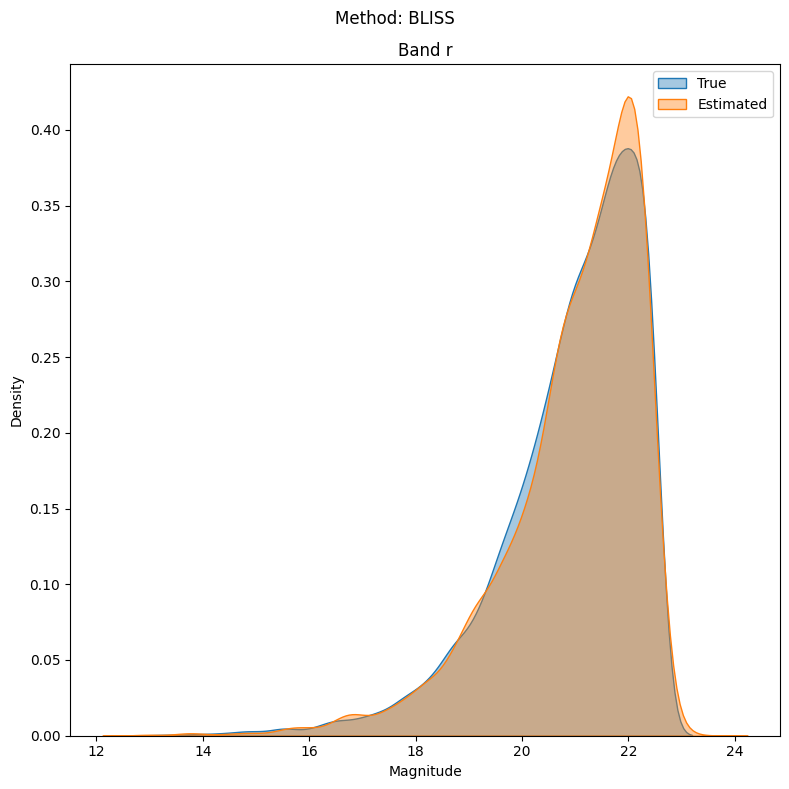

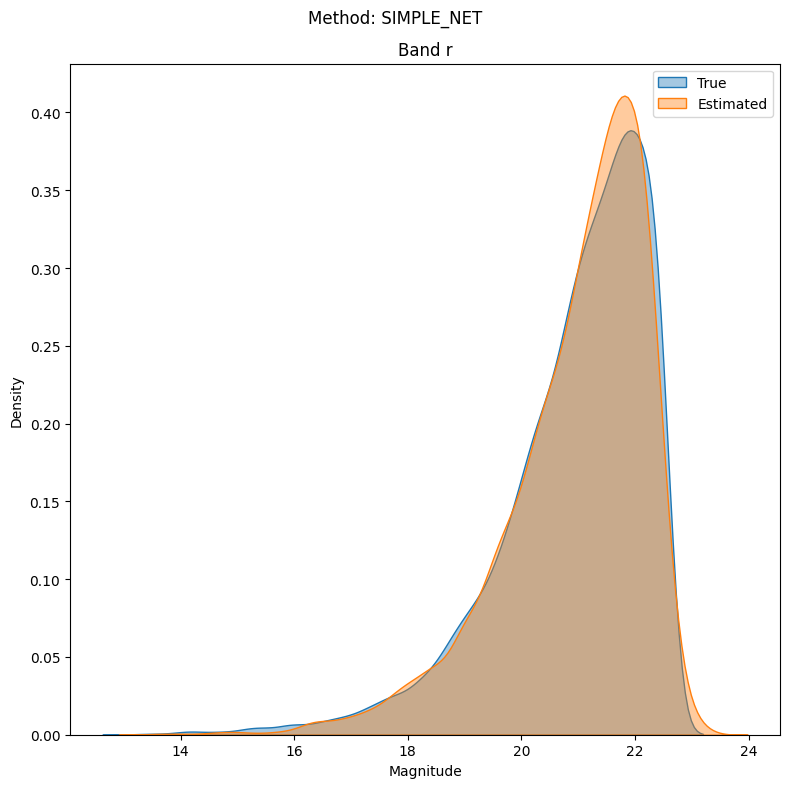

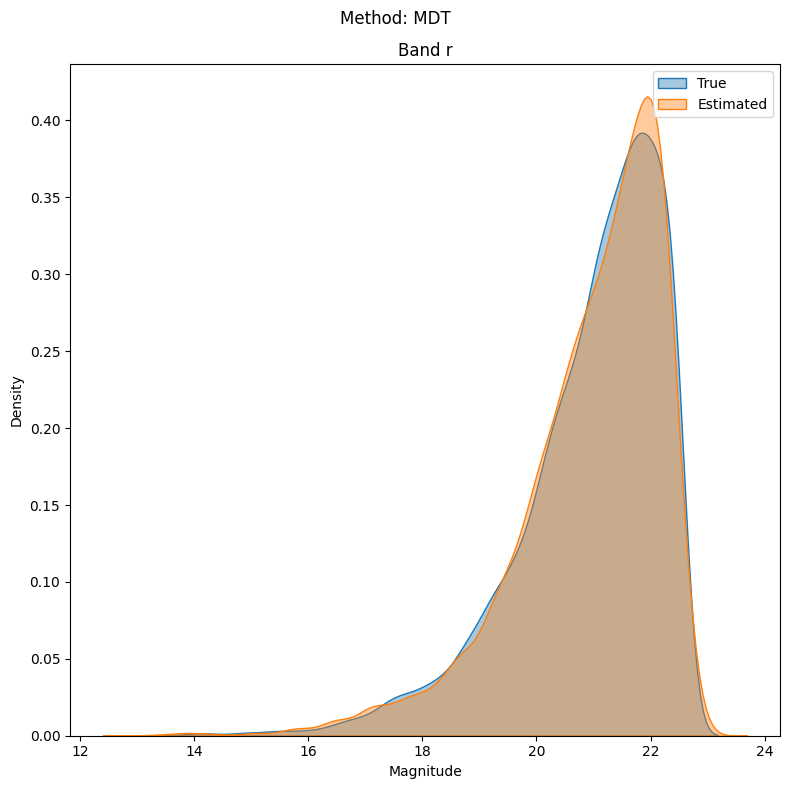

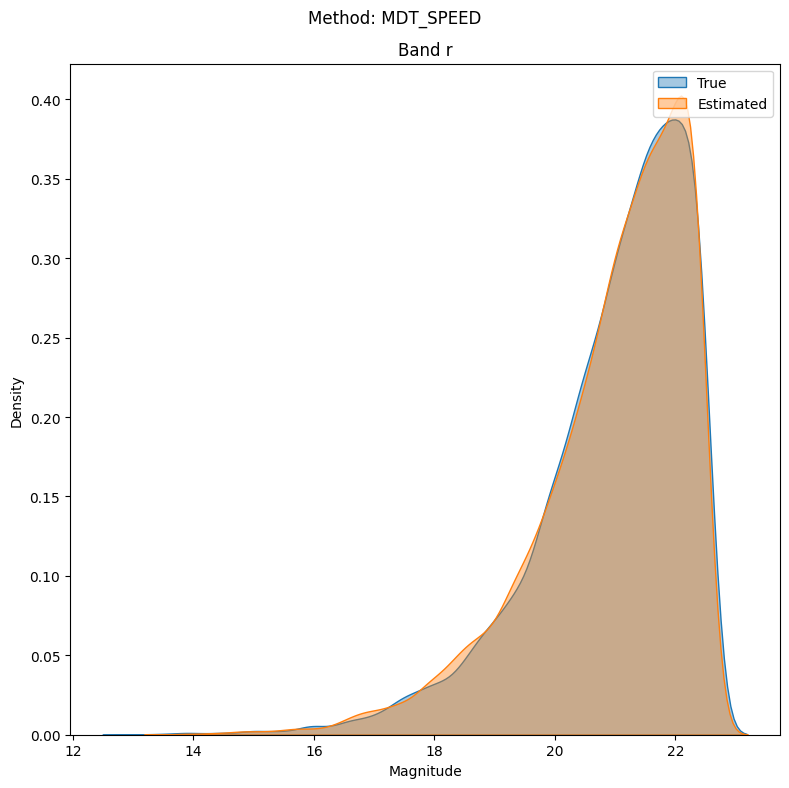

In [22]:
draw_flux_density_plot(draw_kde=True)